In [69]:
from TCLIService.ttypes import TOperationState
from pyhive import hive


import numpy as np

from konlpy.tag import Mecab
# 워드클라우드 관련
from wordcloud import WordCloud
from PIL import Image
# 자연어처리 관련
import nltk
# 파일 처리 관련
import pandas as pd
import os
import re

from nltk import FreqDist
from pprint import pprint
import matplotlib.pyplot as plt
import slack
from tqdm import tqdm


path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' 




In [70]:
try:
    if not os.path.exists("pic"):
        os.mkdir("pic")
except OSError:
    print ('Error: Creating directory. ' +  "pic")

In [71]:
# mecab 기준, 명사 & 형용사 & 동사 & 부사
FEATURE_POS = ['NNG', 'NNP', 'NNB', 'NNBC', 'NR',
               'NP', 'VV', 'VA', 'MAG']


def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 패턴.
    #doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
    
    # 특수문자를 제거하는 패턴.
    doc = re.sub("[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"]", " ", doc)
    
    # 영문 빼고 모두 제거하는 패턴.
    #doc = doc.replace("\n", " ")
    #doc = re.sub("[^A-Za-z ]", "", doc)
    
    return doc

def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    # SW.add("있다")
    SW.add("있어요")
    SW.add("대한")
    SW.add("합니다")
    SW.add("하는")
    
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path, encoding="utf-8") as f:
        for word in f:
            SW.add(word.strip())
            
    return SW

def text_tokenizing(doc, tokenizer): 
    """
    Input Parameter :
    
    doc - tokenizing 하는 실제 데이터.
    tokenizer - token의 단위.
    """
    #tok = PeCab() # 형태소 분석기 선언.
    tok = Mecab()
    
    if tokenizer == "words":
        return [word for word in doc.split() if word not in SW and len(word) > 1]
    
    elif tokenizer == "nouns":
        return [token for token in tok.nouns(doc)]
        
    elif tokenizer == "morphs":
        return [token for token in tok.morphs(doc)]
     
    elif tokenizer == "predefined":
        
        documents = []
        text_pos = [pair for pair in tok.pos(doc) if pair[0] not in SW and len(pair[0]) > 1]
        words = []

        for word, pos in text_pos:
            if pos in FEATURE_POS:
                words.append(word)

        return words



  0%|          | 0/6 [00:00<?, ?it/s]/config/.local/lib/python3.10/site-packages/slack_sdk/web/internal_utils.py:450: UserWarning: client.files_upload() may cause some issues like timeouts for relatively large files. Our latest recommendation is to use client.files_upload_v2(), which is mostly compatible and much stabler, instead.
  warnings.warn(message)


None


 17%|█▋        | 1/6 [00:03<00:16,  3.21s/it]

None


 33%|███▎      | 2/6 [00:06<00:13,  3.39s/it]

None


 50%|█████     | 3/6 [00:09<00:09,  3.28s/it]

None


 67%|██████▋   | 4/6 [00:12<00:06,  3.16s/it]

None


 83%|████████▎ | 5/6 [00:15<00:03,  3.14s/it]

None


100%|██████████| 6/6 [00:19<00:00,  3.19s/it]


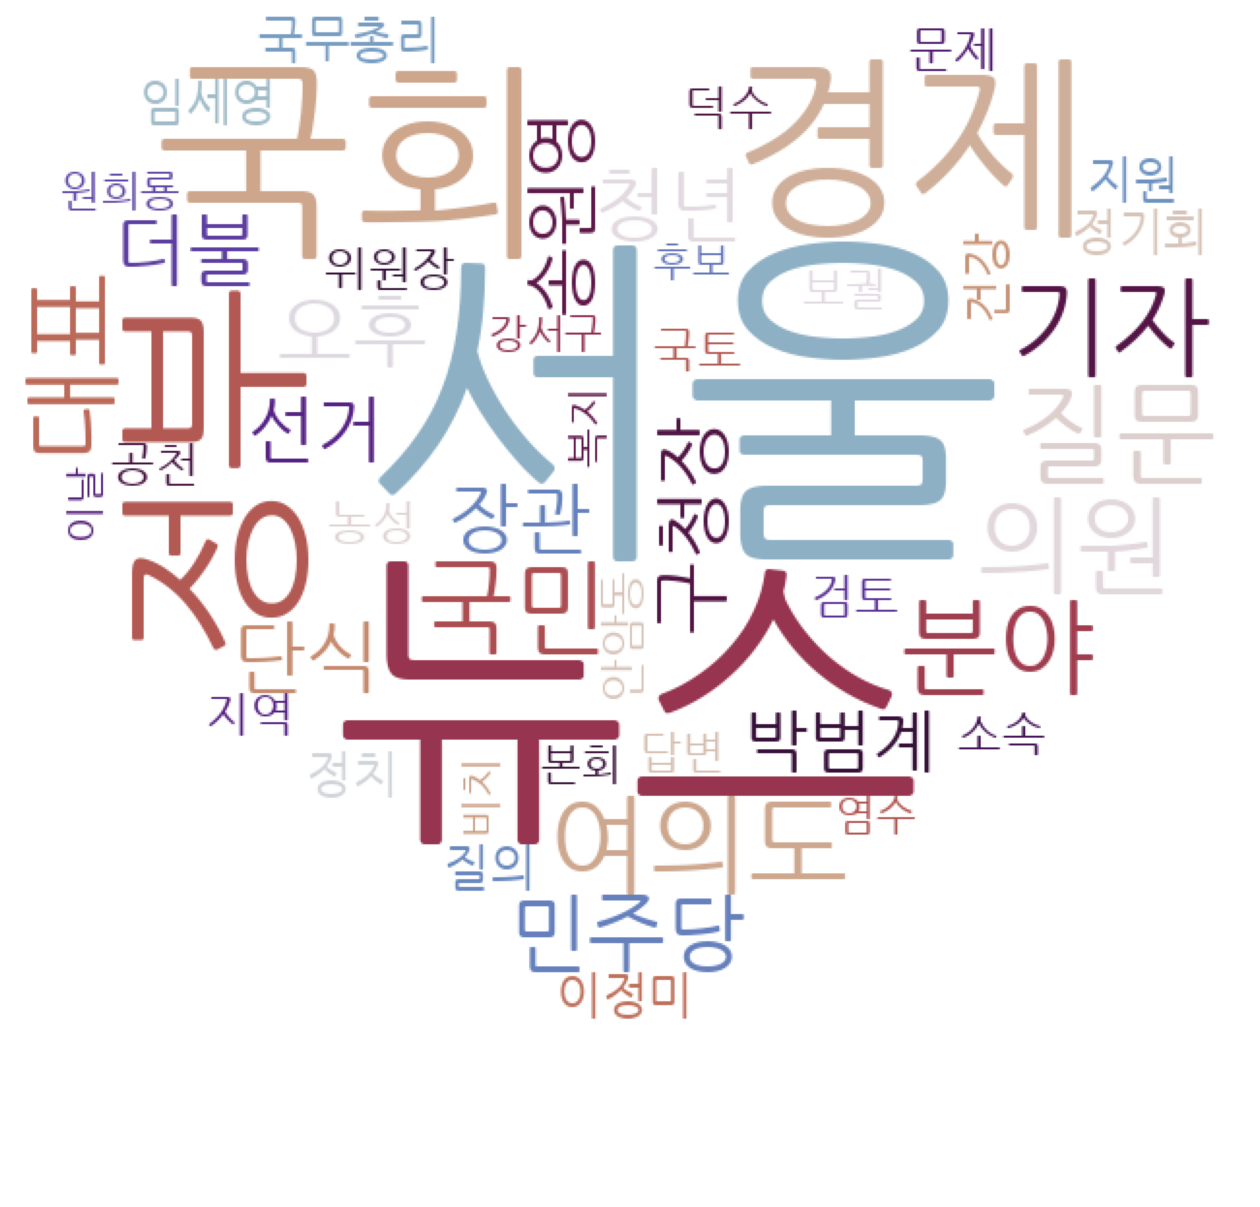

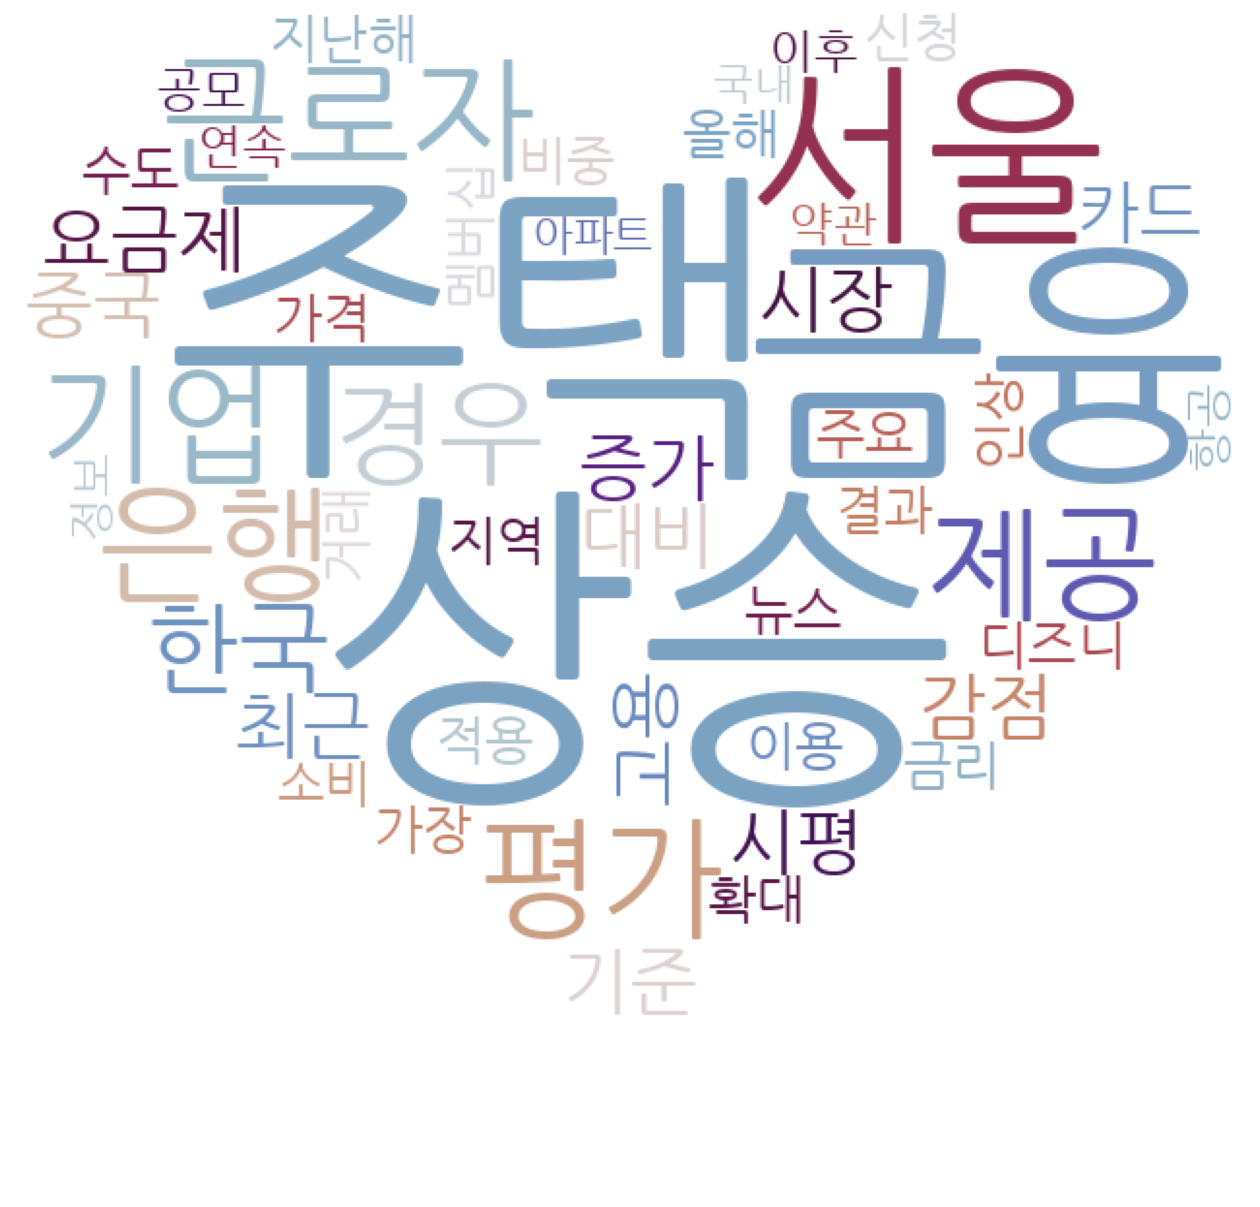

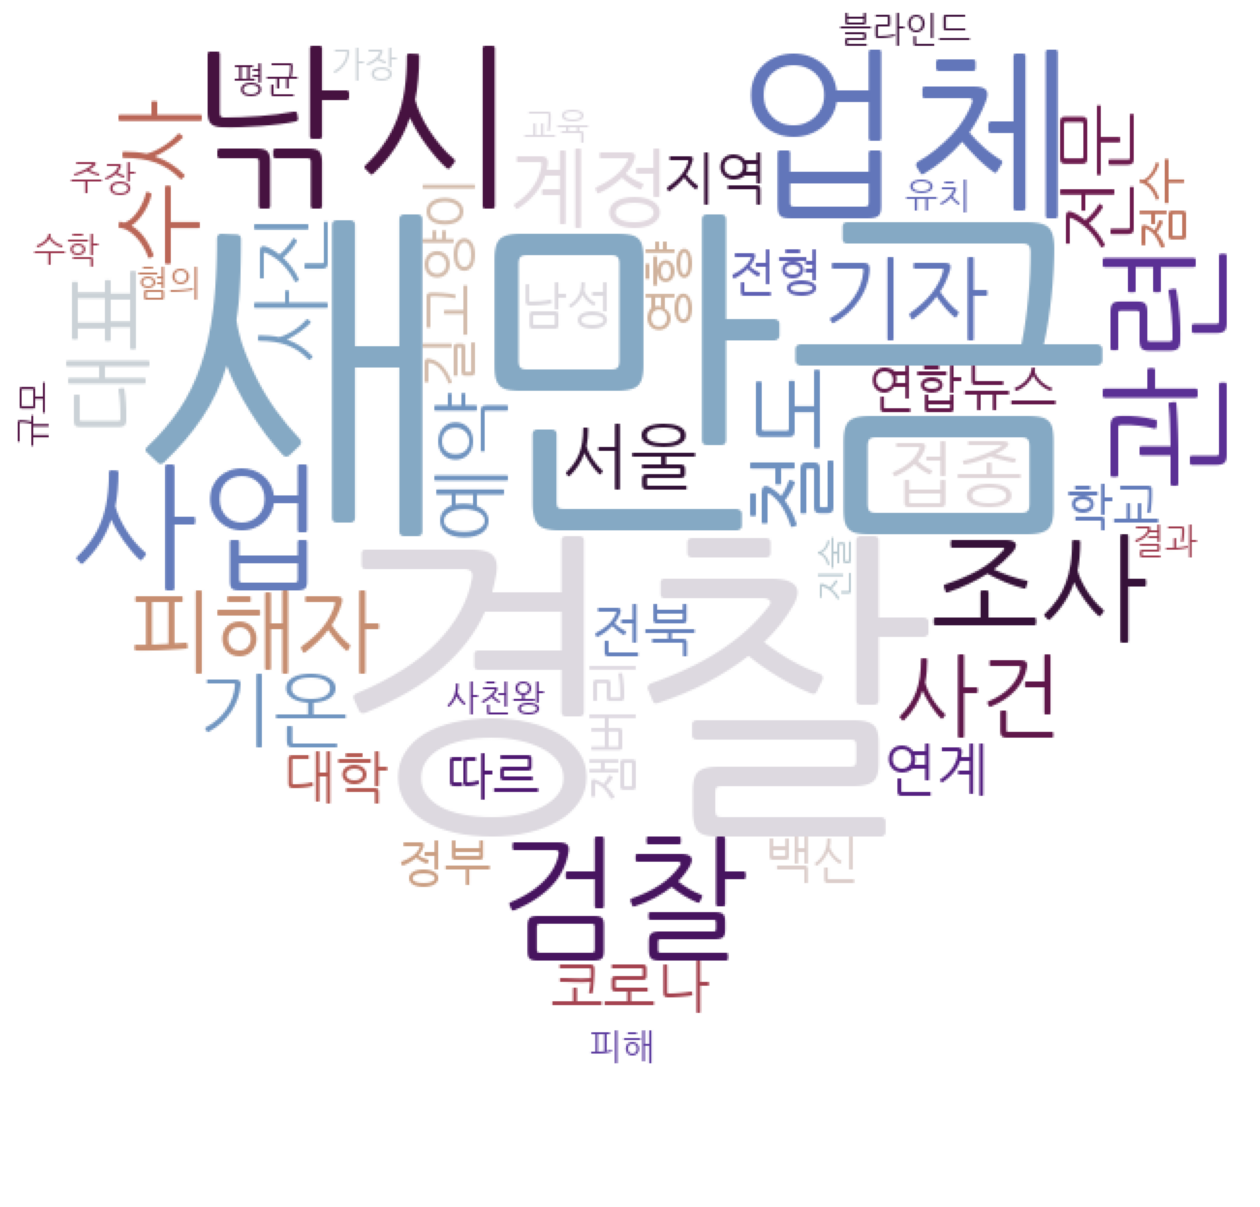

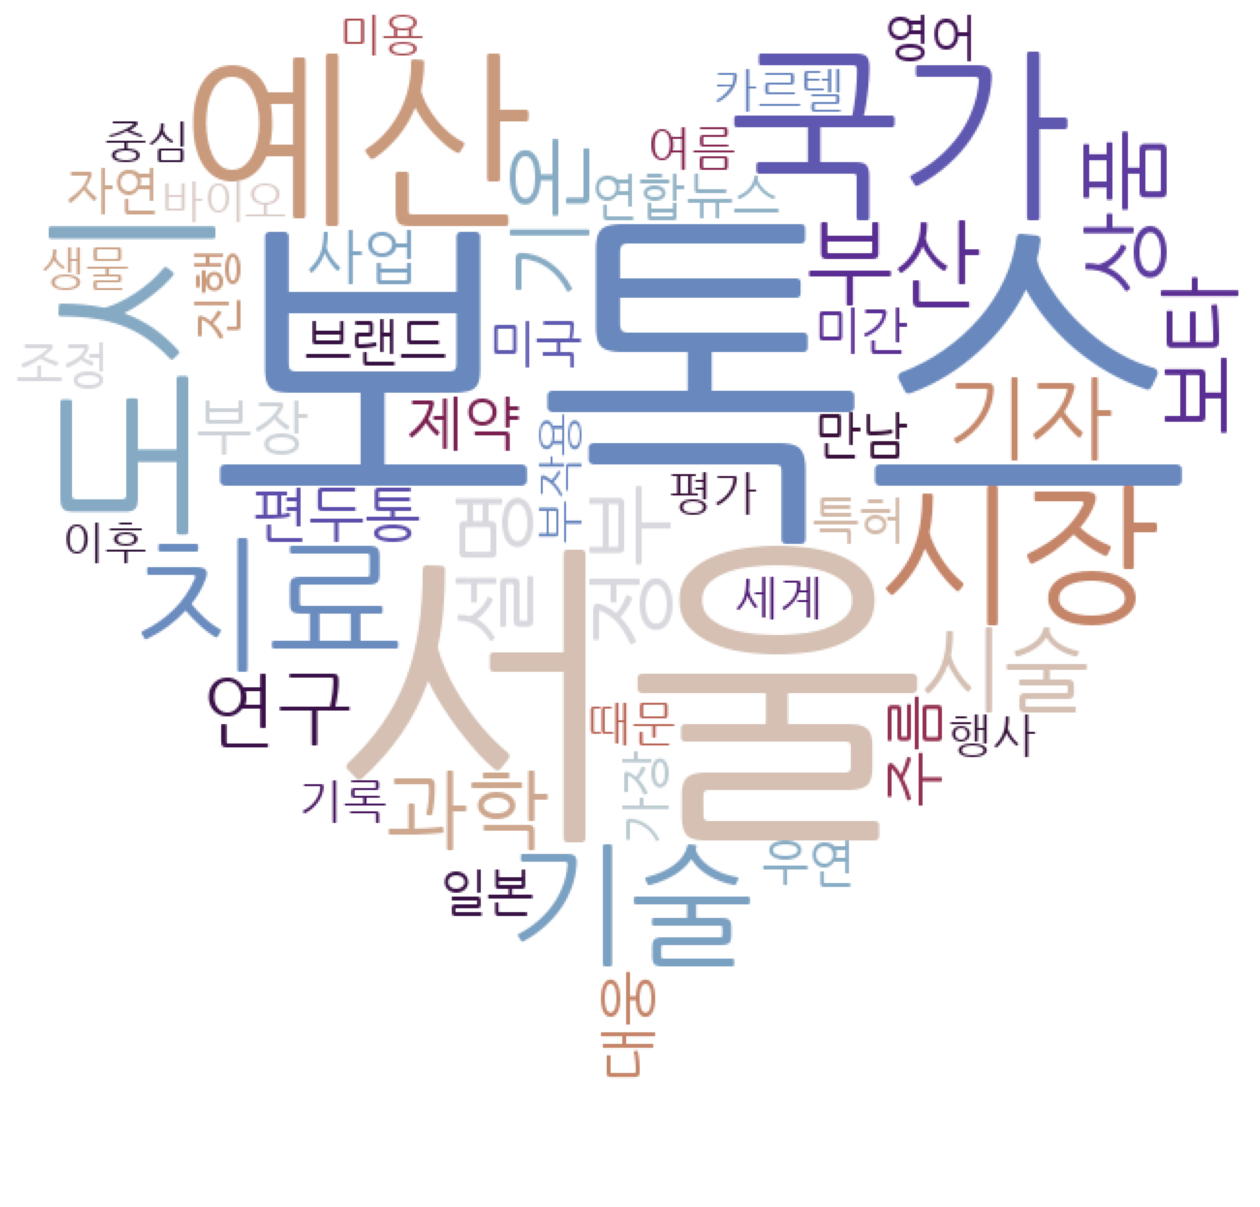

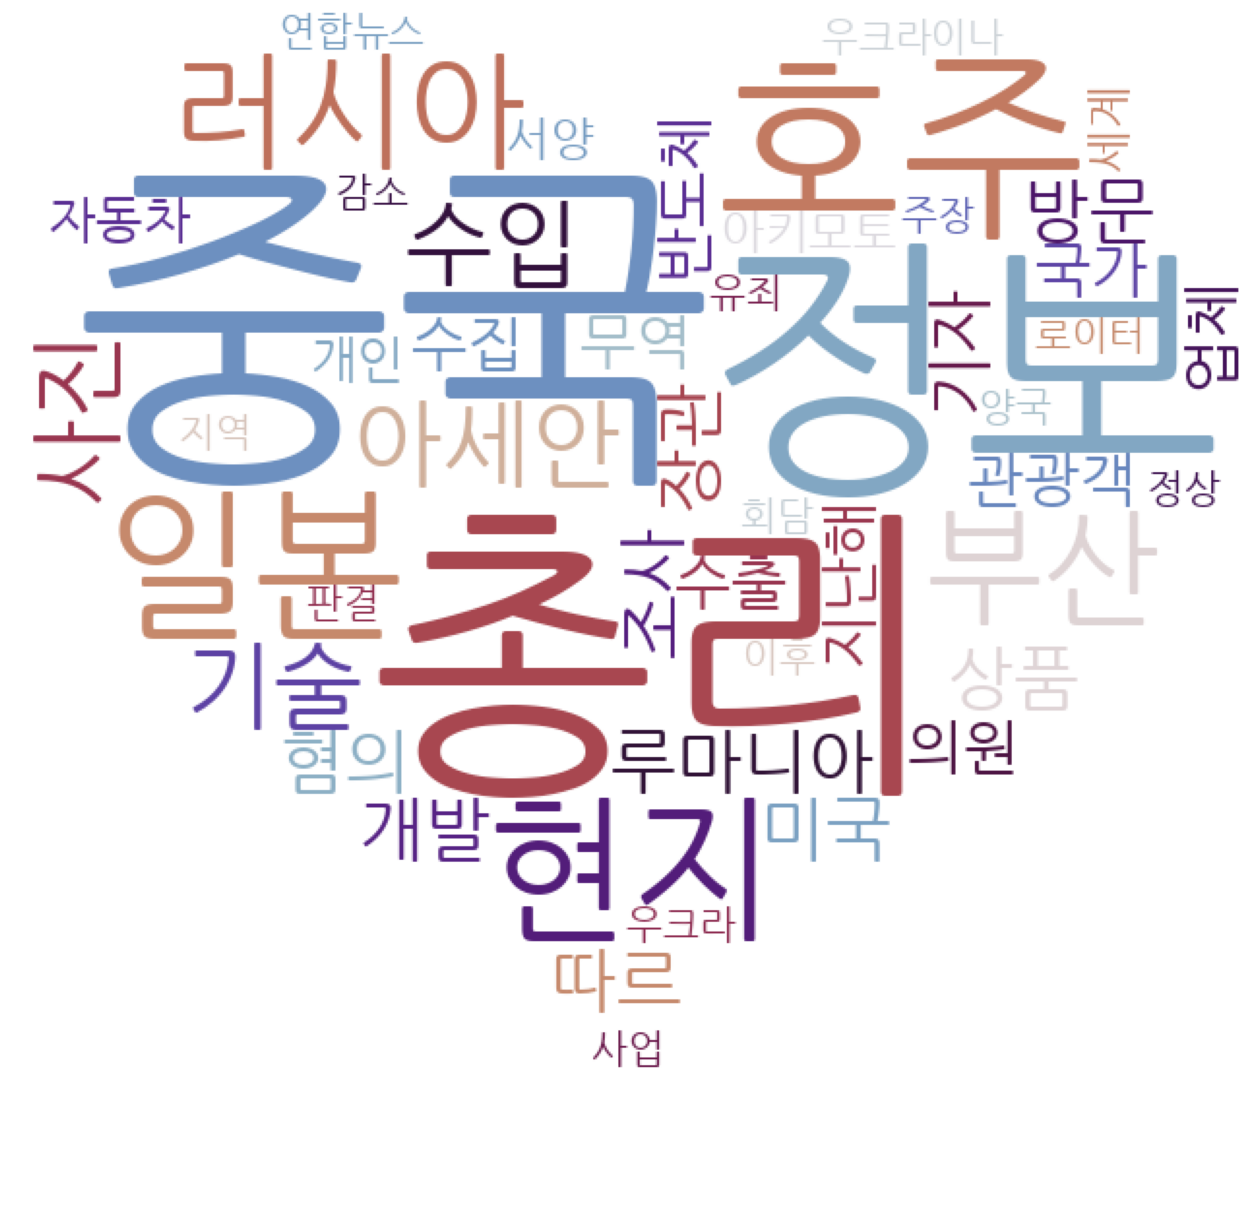

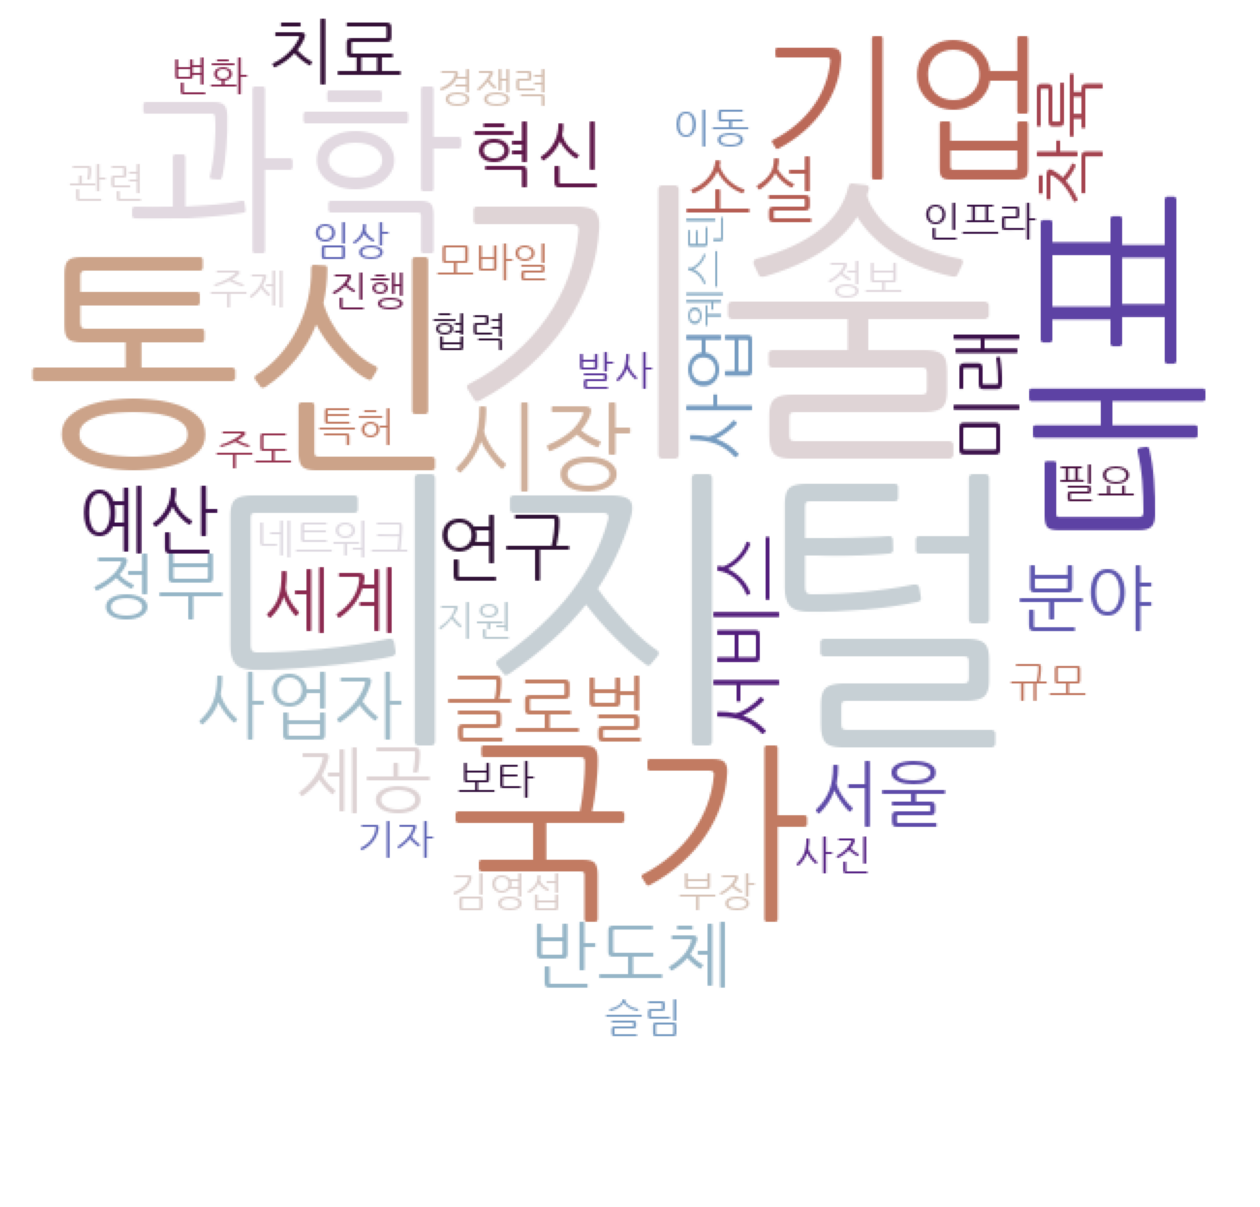

In [74]:
cats = [100, 101, 102, 103 ,104, 105]
page_section_dict = {"100":"정치", "101":"경제", "102":"사회",  "103":"생활/문화", "104":"세계", "105":"IT/과학"}

for cat in tqdm(cats):
    # Hive 서버에 연결합니다.
    conn = hive.Connection(host='15.164.220.245', port=10000, database='test_hadoop')

    # Hive 쿼리를 실행합니다.
    query = "SELECT content FROM test_hadoop10 where category_id = "+ str(cat)
    cursor = conn.cursor()
    cursor.execute(query)

    # 쿼리 결과를 가져옵니다.
    results = cursor.fetchall()

    # 결과를 출력하거나 처리합니다.
    #for row in results:
    #   print(row)

    #result_dicts = [{'content': row[0]} for row in results]
    # 연결을 닫습니다.
    conn.close()


    ###########
    

    tokenizer = "predefined" # "words" / "nouns" / "morphs" / "predefined"

    # stopwords : 불용어 --> token filtering.
    SW = define_stopwords("stopwords-ko.txt")

    #document = str(' '.join(results))
    document = pd.DataFrame(results, columns=['content'])

    documents = document.content
    #documents = document.contents
    tokenized_documents = documents.apply(text_cleaning)\
                                .apply(func=text_tokenizing, tokenizer=tokenizer)#.apply(lambda x: text_tokenizing(x, tokenizer))
                                
    #tokenized_documents # 2d list


    total_tokens = [token for doc in tokenized_documents for token in doc]
    #print(len(total_tokens))

    text = nltk.Text(total_tokens)
    #print(len(set(text.tokens)))



    topN = 50

    x = []
    y = []
    wordInfo = dict()

    for vocab, count in text.vocab().most_common(topN):
        x.append(vocab)
        y.append(count)
        wordInfo[vocab] = count
        
        
    mask = np.array(Image.open("ht.png"))
    wordcloud = WordCloud(font_path = path,
                        relative_scaling = 0.2,
                        mask=mask,
                        background_color='white',
                        colormap="twilight"
                        ).generate_from_frequencies(wordInfo)
    plt.figure(figsize=(16,16))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig("./pic/test_"+str(cat)+".png")
    #plt.show()



In [75]:
for cat in tqdm(cats):

    client = slack.WebClient(token='xoxb')
    response = client.files_upload(
        channels="#일반",
        file='./pic/test_'+str(cat)+'.png',
        title=page_section_dict.get(str(cat)),
        filetype='image/png'
    )
    assert response["ok"]

  0%|          | 0/6 [00:00<?, ?it/s]

None


 17%|█▋        | 1/6 [00:03<00:17,  3.51s/it]

None


 33%|███▎      | 2/6 [00:06<00:13,  3.32s/it]

None


 50%|█████     | 3/6 [00:09<00:09,  3.27s/it]

None


 67%|██████▋   | 4/6 [00:12<00:06,  3.08s/it]

None


 83%|████████▎ | 5/6 [00:15<00:03,  3.02s/it]

None


100%|██████████| 6/6 [00:18<00:00,  3.15s/it]
